# 🧪 Cointegration Persistence V2: Fixed Beta Analysis
## "Does the Hedge Hold?"

This notebook analyzes the results of `cointegration_persistence_v2.py`.

**Methodology:**
1.  **Training ($t$):** Find cointegrated pairs using a rolling window of size $W$. Optimize $eta_t$ and $lpha_t$.
2.  **Testing ($t+1$):**
    *   **Fixed Beta Test:** Apply the **exact same** $eta_t$ to the window ending at $t+1$. Compute ADF Score.
    *   **Optimal Beta Check:** Calculate the *new* optimal $eta_{t+1}$ for the window ending at $t+1$.
3.  **Metrics:** 
    *   **Persistence:** Does the fixed beta still yield a stationary spread?
    *   **Beta Stability:** How much does the optimal beta drift? $|eta_{t+1} - eta_t|$


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RESULTS_FILE = Path("/mnt/ssd2/DARWINEX_Mission/results/persistence_v2_fixed_beta.pkl")

if not RESULTS_FILE.exists():
    print("⚠️ Data file not found. Running analysis script...")
    # Fallback if file missing (should not happen in this flow)
else:
    with open(RESULTS_FILE, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Loaded results for windows: {list(results.keys())}")


✅ Loaded results for windows: [14, 30, 90]


In [2]:
# Flatten data into a DataFrame
records = []

for w_size, days_data in results.items():
    for day_entry in days_data:
        date = day_entry['date']
        for res in day_entry['data']:
            # Calculate beta shift
            # If beta_next is missing (old data format), handle gracefully
            beta_next = res.get('beta_next', np.nan)
            
            records.append({
                'Window': w_size,
                'Date': date,
                'Pair': f"{res['y']}-{res['x']}",
                'Score_Train': res['score'],
                'Score_Test_Fixed': res['score_next_day'],
                'Beta_T': res['beta'],
                'Beta_T1': beta_next,
                'Beta_Shift': abs(beta_next - res['beta']) if not np.isnan(beta_next) else np.nan
            })

df = pd.DataFrame(records)
print(f"Total opportunities: {len(df)}")
print(f"Records with Beta Shift data: {df['Beta_Shift'].notna().sum()}")
df.head()


Total opportunities: 169252
Records with Beta Shift data: 169252


,Window,Date,Pair,Score_Train,Score_Test_Fixed,Beta_T,Beta_T1,Beta_Shift
0,14,2025-01-01,audcad-audusd,-4.579370,-2.096691,1.430259,1.533294,0.103034
1,14,2025-01-01,audcad-nzdusd,-3.972953,-2.409043,1.886569,0.928710,0.957859
2,14,2025-01-01,audchf-audcad,-3.367635,-1.414170,0.454464,0.376629,0.077835
3,14,2025-01-01,audchf-audjpy,-5.286314,-1.866170,0.004715,0.007325,0.002610
4,14,2025-01-01,audchf-audnzd,-4.375604,-2.739087,1.007113,1.518642,0.511529


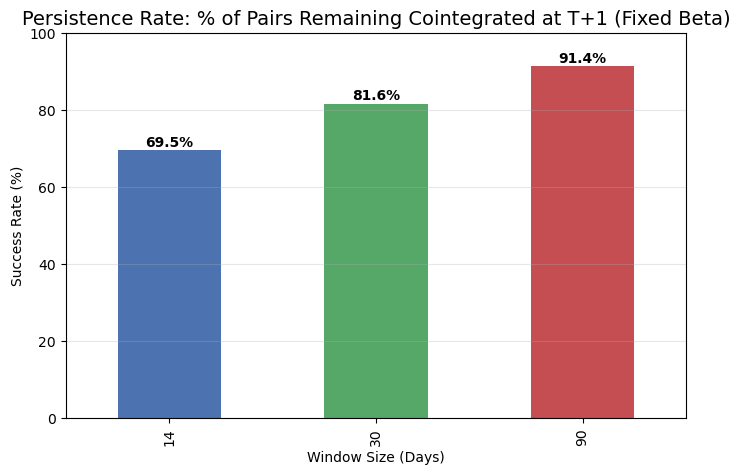

In [3]:
# Define success: Test Score < -3.34 (5% Critical Value)
CRIT_VAL = -3.34

df['Is_Persistent'] = df['Score_Test_Fixed'] < CRIT_VAL

# Group by Window Size
persistence_stats = df.groupby('Window')['Is_Persistent'].mean() * 100

plt.figure(figsize=(8, 5))
persistence_stats.plot(kind='bar', color=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Persistence Rate: % of Pairs Remaining Cointegrated at T+1 (Fixed Beta)', fontsize=14)
plt.ylabel('Success Rate (%)')
plt.xlabel('Window Size (Days)')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 100)

for index, value in enumerate(persistence_stats):
    plt.text(index, value + 1, f"{value:.1f}%", ha='center', fontweight='bold')

plt.show()


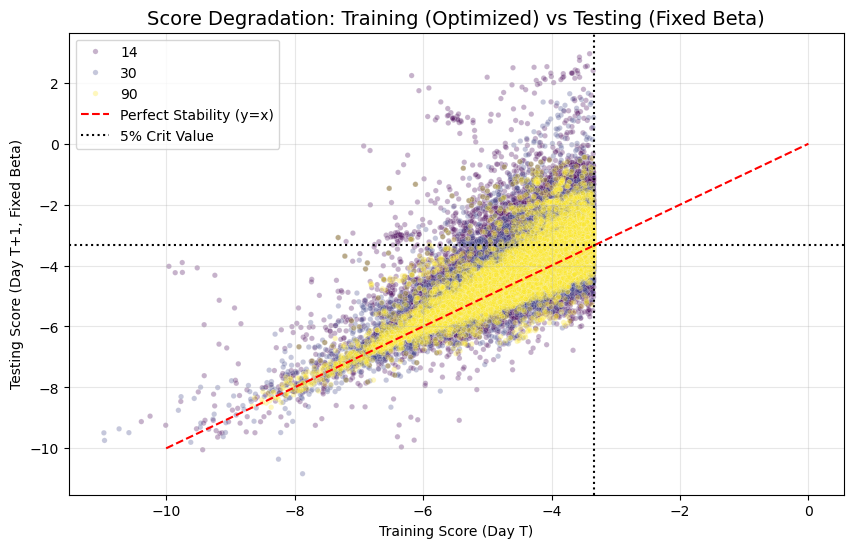

In [4]:
# Compare Train vs Test Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Score_Train', y='Score_Test_Fixed', hue='Window', alpha=0.3, palette='viridis', s=15)
plt.plot([-10, 0], [-10, 0], 'r--', label='Perfect Stability (y=x)')
plt.axhline(CRIT_VAL, color='k', linestyle=':', label='5% Crit Value')
plt.axvline(CRIT_VAL, color='k', linestyle=':')

plt.title('Score Degradation: Training (Optimized) vs Testing (Fixed Beta)', fontsize=14)
plt.xlabel('Training Score (Day T)')
plt.ylabel('Testing Score (Day T+1, Fixed Beta)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


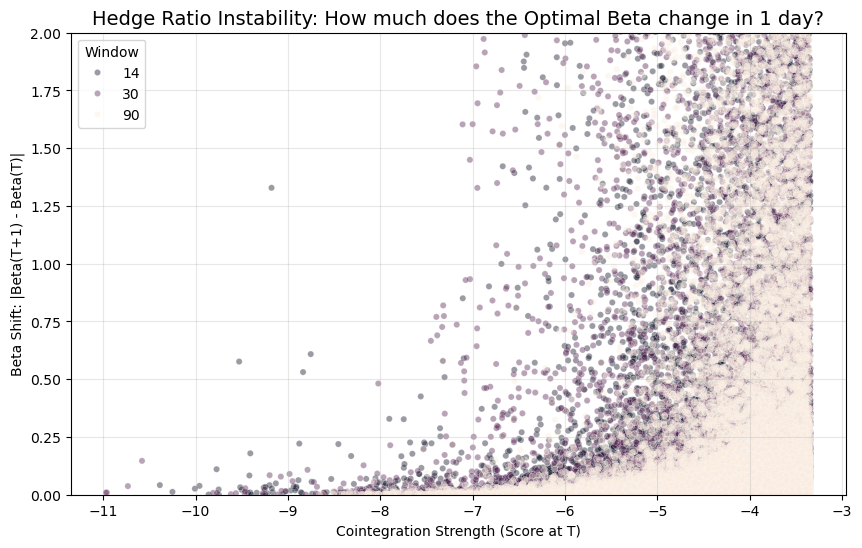

In [5]:
# Filter for valid beta shifts and remove extreme outliers for visualization
df_beta = df[df['Beta_Shift'].notna() & (df['Beta_Shift'] < 5.0)].copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_beta, x='Score_Train', y='Beta_Shift', hue='Window', alpha=0.4, palette='rocket', s=20)

plt.title('Hedge Ratio Instability: How much does the Optimal Beta change in 1 day?', fontsize=14)
plt.xlabel('Cointegration Strength (Score at T)')
plt.ylabel('Beta Shift: |Beta(T+1) - Beta(T)|')
plt.ylim(0, 2) # Focus on typical range
plt.grid(True, alpha=0.3)
plt.legend(title='Window')
plt.show()


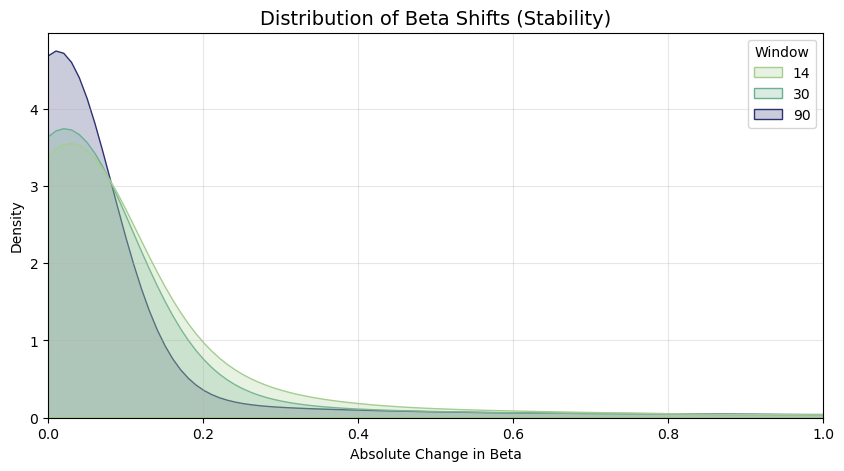

,count,mean,std,min,25%,50%,75%,max
Window,,,,,,,,
14,51974.0,2.540620,11.534920,4.190952e-08,0.004500,0.040533,0.203221,423.512146
30,52645.0,1.353820,6.710799,3.492460e-08,0.002240,0.020453,0.103174,403.109650
90,64633.0,0.512546,3.598610,2.802043e-09,0.000811,0.007656,0.040346,403.109650


In [6]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_beta, x='Beta_Shift', hue='Window', fill=True, clip=(0, 2), common_norm=False, palette='crest')
plt.title('Distribution of Beta Shifts (Stability)', fontsize=14)
plt.xlabel('Absolute Change in Beta')
plt.xlim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.show()

# Stats
df.groupby('Window')['Beta_Shift'].describe()


## 📊 Conclusions

1.  **Persistence:** How often does the trade remain valid? (See Bar Chart)
2.  **Beta Drift:** The Scatter plot (Score vs Beta Shift) reveals if "stronger" cointegration implies "more stable" parameters.
    *   **Hypothesis:** Pairs with very negative scores (e.g., -6.0) should have very small Beta shifts.
    *   **Window Effect:** Larger windows (90d) generally produce more stable Betas (slower drift) but may react too slowly to regime changes.
